In [1]:
import tensorflow as tf

In [5]:
!pip install matplotlib
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/103.7 kB ? eta -:--:--
     ----------- ---------------------------- 30.7/103.7 kB ? eta -:--:--
     ----------- ---------------------------- 30.7/103.7 kB ? eta -:--:--
     -----------------------------------  102.4/103.7 kB 737.3 kB/s eta 0:00:01
     ------------------------------------ 103.7/103.7 kB 663.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
    --------------------------------------- 0.1/7.5 MB 2.2 MB/s eta 0:00:04
   - -------------------------------------- 0.3/7.5 MB 2.4 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/7.5 MB 2.7 MB/s eta 0:00:03
   --- ------------------------------------ 0.7/7.5 MB 2.8 MB/s eta 0:00:03
   ---- ----------------------------------- 0.8/7.5 MB 2.7 MB/s eta 0:00:03
   ----- ---------------------------------- 1.0/7.5 MB 2.8 MB/s eta 0:00:03
   ------ --------------------

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 10
CHANNELS = 3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
dataset.class_names[0]

'Potato___Early_blight'

In [10]:
for image_batch,lable_batch in dataset.take(1):
    print(image_batch.shape)
    print(lable_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


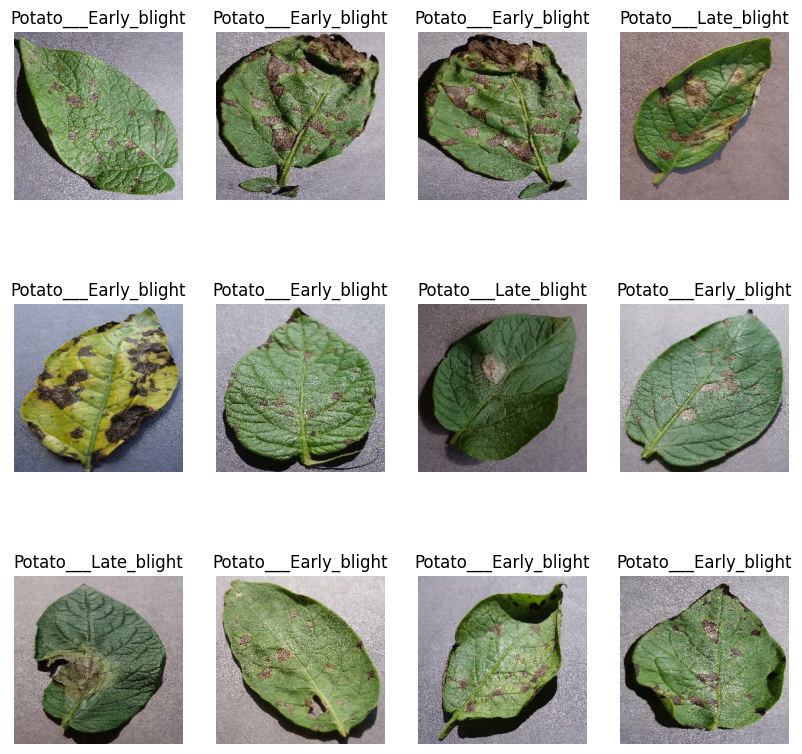

In [11]:
plt.figure(figsize=(10,10))
for image_batch,lable_batch in dataset.take(1):
    for i in range(12):
            ax=plt.subplot(3,4,i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[lable_batch[i]])
            plt.axis("off")

In [12]:
len(dataset)

68

In [13]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds=dataset.take(54)
len(train_ds)


54

In [15]:
val_size=0.1

In [16]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_Size=10000):
    assert (train_split + test_split + val_split)==1
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_Size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)


In [18]:
len(test_ds)

8

In [19]:
len(val_ds)

6

In [20]:
len(train_ds)

54

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 106s 2s/step - loss: 0.9051 - accuracy: 0.4913 - val_loss: 0.9117 - val_accuracy: 0.4375
Epoch 2/10
54/54 [==============================] - 88s 2s/step - loss: 0.6343 - accuracy: 0.7037 - val_loss: 0.4662 - val_accuracy: 0.7812
Epoch 3/10
54/54 [==============================] - 85s 2s/step - loss: 0.5352 - accuracy: 0.7755 - val_loss: 0.3736 - val_accuracy: 0.8229
Epoch 4/10
54/54 [==============================] - 85s 2s/step - loss: 0.3084 - accuracy: 0.8692 - val_loss: 0.2445 - val_accuracy: 0.9062
Epoch 5/10
54/54 [==============================] - 567s 11s/step - loss: 0.2851 - accuracy: 0.8831 - val_loss: 0.2300 - val_accuracy: 0.9010
Epoch 6/10
54/54 [==============================] - 88s 2s/step - loss: 0.2383 - accuracy: 0.9039 - val_loss: 0.4399 - val_accuracy: 0.8125
Epoch 7/10
54/54 [==============================] - 80s 1s/step - loss: 0.2496 - accuracy: 0.9057 - val_loss: 0.2424 - val_accuracy: 0.8906
Epoch 8/10
54/54 

In [29]:
history.params


{'verbose': 1, 'epochs': 10, 'steps': 54}

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

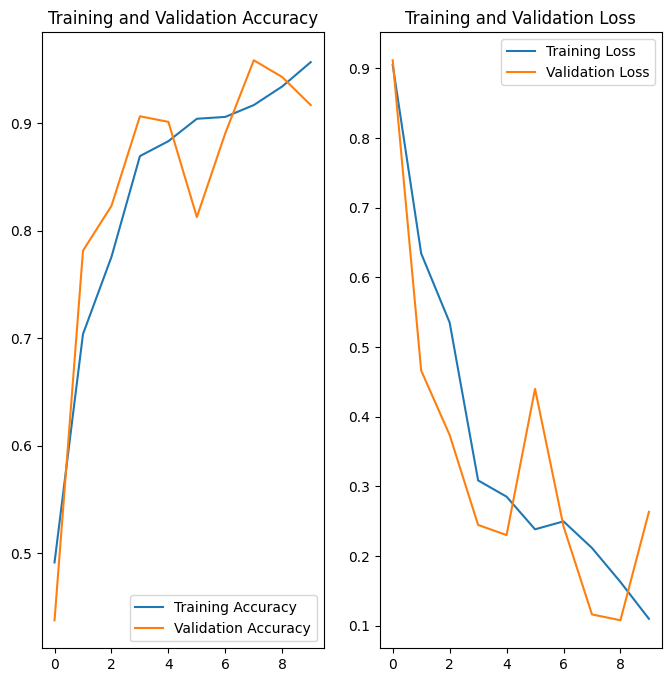

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image is :
actual lable is : Potato___Early_blight
1/1 [==============================] - 0s 295ms/step
predicted batch is : Potato___Early_blight


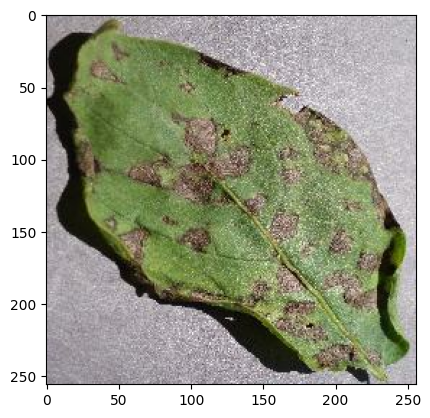

In [33]:
import numpy as np
for image_batch,lable_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_lable = lable_batch[0].numpy()
    print("First image is :")
    plt.imshow(first_image)
    print("actual lable is :",class_names[first_lable])
    batch_prediction = model.predict(image_batch)
    print("predicted batch is :",class_names[np.argmax(batch_prediction[0])])

In [34]:
len(batch_prediction)

32

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


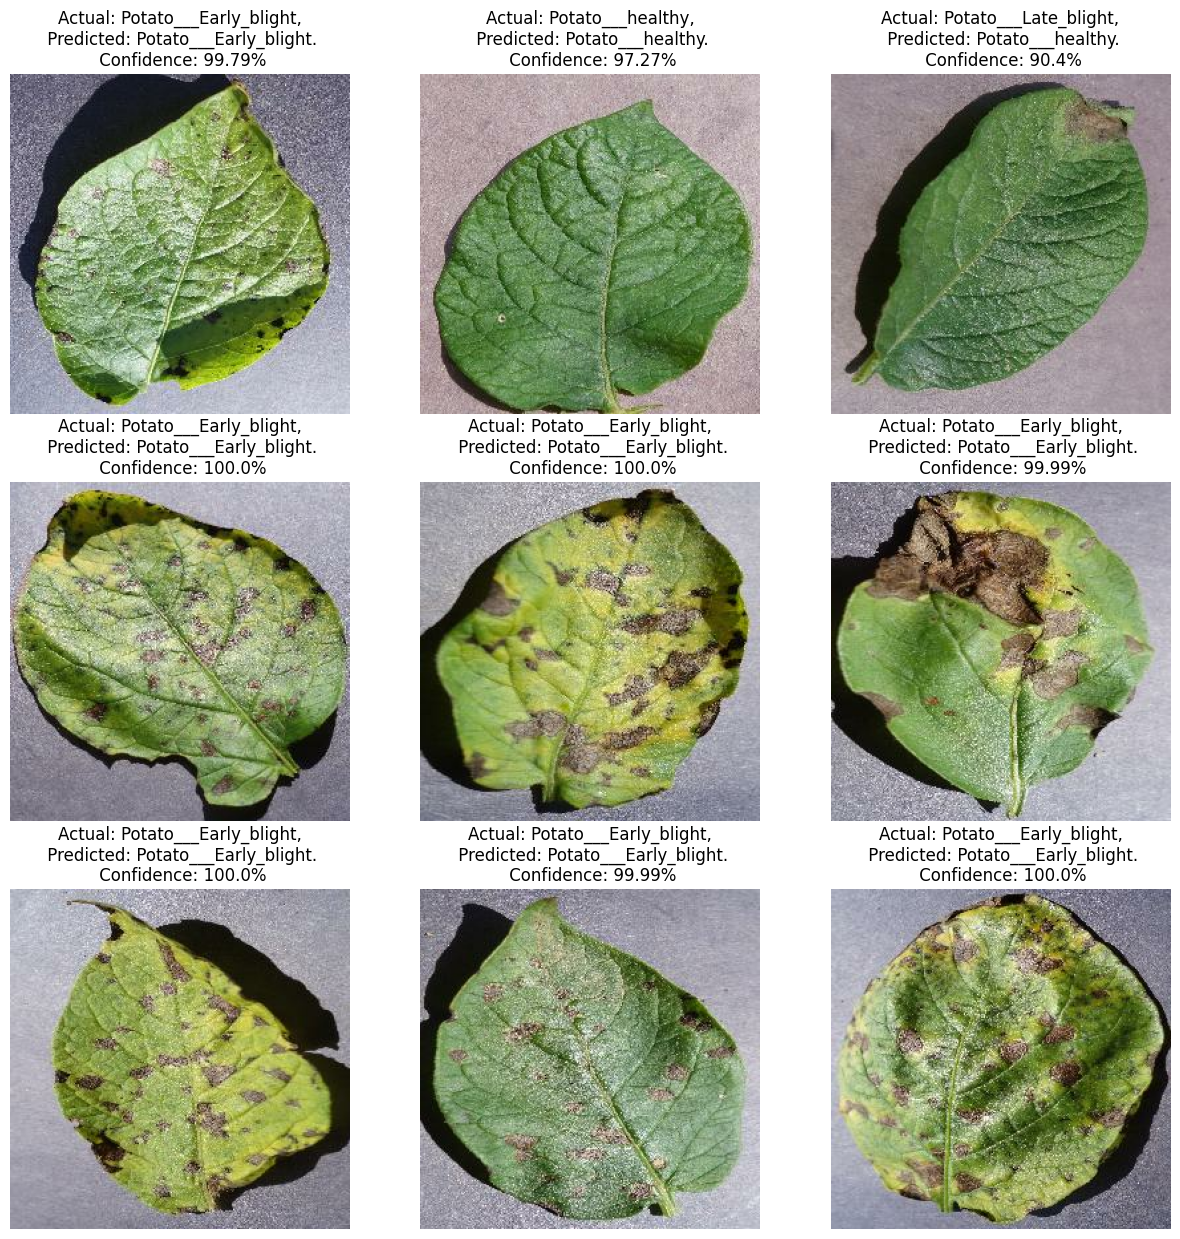

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [44]:
model.save("saved_model2/2", save_format="tf")


INFO:tensorflow:Assets written to: saved_model2/2\assets


INFO:tensorflow:Assets written to: saved_model2/2\assets


In [42]:
print(model.summary())  # Check if model loads properly


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [ ]:
model.save("../saved_model2/model.keras")

FileNotFoundError: [Errno 2] No such file or directory: 'saved_model3/model.keras'

In [51]:
model.save("model.h5")
# loaded_model = tf.keras.models.load_model("model.h5")


c:\Users\ROSHAN\.conda\envs\tfod\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:

model.save(f"models/3")

INFO:tensorflow:Assets written to: models/3\assets


INFO:tensorflow:Assets written to: models/3\assets


In [54]:
model.save("potatoes.h5")

c:\Users\ROSHAN\.conda\envs\tfod\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
model.save('my_model.keras')